In [32]:
!git clone https://github.com/yarathealmighty/dumps.git
!cd dumps/data
!git clone https://https://huggingface.co/datasets/yarathealmighty/dumps

fatal: destination path 'dumps' already exists and is not an empty directory.
fatal: destination path 'dumps' already exists and is not an empty directory.


In [2]:
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 429.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is 

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import dumps.utils as utils
import matplotlib.pyplot as plt

In [4]:
def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["question"],examples['answer'], truncation=True, padding="max_length", max_length=256)

    # Change this to real number
    examples["label"] = float(label)
    return examples

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    # Compute accuracy
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.5]) / len(single_squared_errors)

    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

def to_ds(df_og,debug_mode=False):
  df = utils.get_qas(df_og)

  if debug_mode:
    df = utils.normalize_scores(df,False)
    df = df[df['normalized_score'].notna()]

  else:
    df = utils.normalize_scores(df)
    df = df[df['score'].notna()]

  #se as in StackExchange
  se = Dataset.from_pandas(df)
  train_test_split = se.train_test_split(test_size=0.2, seed=42)

  se = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
  })

  for split in se:
    se[split] = se[split].map(preprocess_function, remove_columns=["score",'__index_level_0__'])

  return se

In [7]:
#--------------------------------------<paths>---------------------------------------------

FILENAME = 'movies.csv'

#--------------------------------------<model_params>--------------------------------------

BASE_MODEL = "distilbert/distilbert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 5

#------------------------------------------------------------------------------------------

In [6]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# using <insert current stack exchange forum here> SE here
se = to_ds(pd.read_csv('dumps/data/parsed/' + FILENAME))
se.save_to_disk(FILENAME[:-4])

Map:   0%|          | 0/19983 [00:00<?, ? examples/s]

Map:   0%|          | 0/4996 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19983 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4996 [00:00<?, ? examples/s]

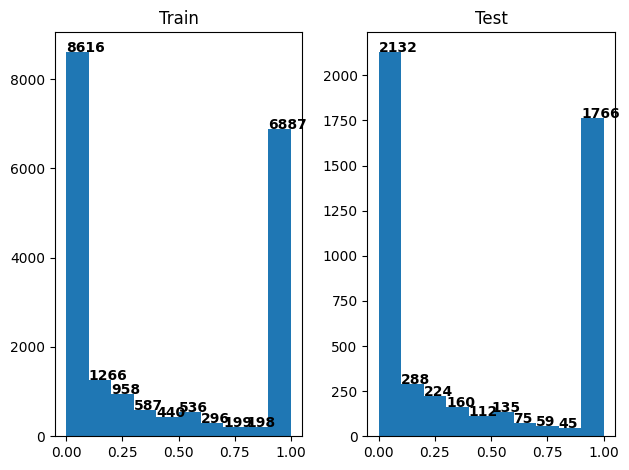

In [9]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Test");
train_distributions = axs[0].hist(se['train']["label"], bins=10)
test_distributions = axs[1].hist(se['test']["label"], bins=10)

for distributions, ax in zip([train_distributions, test_distributions], axs):
    for j in range(10):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

In [25]:
training_args = TrainingArguments(
    output_dir="models/distilbert/"+FILENAME[:-4],
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [26]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [28]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=se["train"],
    eval_dataset=se["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,0.042900,0.230427,0.230427,0.388554,-0.144275,0.819055
2,0.118500,0.248663,0.248663,0.396227,-0.234833,0.795236
3,0.078800,0.255097,0.255097,0.393176,-0.266784,0.771817
4,0.048700,0.267400,0.267400,0.396897,-0.327878,0.753203
5,0.036200,0.271629,0.271629,0.396096,-0.348879,0.745396


TrainOutput(global_step=6245, training_loss=0.06756700114119615, metrics={'train_runtime': 2391.9158, 'train_samples_per_second': 41.772, 'train_steps_per_second': 2.611, 'total_flos': 6617622050357760.0, 'train_loss': 0.06756700114119615, 'epoch': 5.0})

In [42]:
trainer.eval_dataset=se["test"]
eval = trainer.evaluate()

EVAL_FILENAME = "eval_"+FILENAME[:-4]+".txt"

with open(EVAL_FILENAME, "w") as file:
    file.write(str(eval))
    file.close()

In [ ]:
# early modellek kiértékelése

In [38]:
# ----------------------------------------------------------<HF params>----------------------------------------------------------

model_repo_id = 'yarathealmighty/test-movies'
ds_repo_id = 'yarathealmighty/dumps'
access_token = 'hf_yourtokenhere'

# --------------------------------------------------------<HF code below>--------------------------------------------------------

from huggingface_hub import HfApi

api = HfApi()

api.upload_folder(
    folder_path="models/distilbert/"+FILENAME[:-4],
    repo_id=model_repo_id,
    repo_type="model",
    token=access_token
)

se['train'].push_to_hub(
    'yarathealmighty/dumps',
    'train',
    token=access_token
)
se['test'].push_to_hub(
    'yarathealmighty/dumps',
    'test',
    token=access_token
)

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/876 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/yarathealmighty/dumps/commit/95ac892c6ec6af3242d2ad405a4eb47040e11163', commit_message='Upload dataset', commit_description='', oid='95ac892c6ec6af3242d2ad405a4eb47040e11163', pr_url=None, pr_revision=None, pr_num=None)